In [ ]:
pip install tensorflow pandas numpy matplotlib

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Carregar dados
file_path = 'selic.csv'  # Substitua pelo caminho do seu arquivo CSV
data = pd.read_csv(file_path)
selic_values = data['selic'].values.reshape(-1, 1)  # Substitua 'selic' pela sua coluna de taxa SELIC

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
selic_scaled = scaler.fit_transform(selic_values)

# Preparar dados para LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12  # Número de meses anteriores a considerar
X, Y = create_dataset(selic_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Configurar o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo com Early Stopping
model.fit(X_train, Y_train, validation_split=0.2, batch_size=1, epochs=100, callbacks=[early_stopping])

# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter as previsões para a escala original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)



Epoch 1/100
3502/3502 [==============================] - 42s 11ms/step - loss: 7.4592e-04 - val_loss: 8.5196e-05
Epoch 2/100
3502/3502 [==============================] - 40s 11ms/step - loss: 3.1942e-04 - val_loss: 1.7170e-04
Epoch 3/100
3502/3502 [==============================] - 45s 13ms/step - loss: 2.1614e-04 - val_loss: 3.8485e-05
Epoch 4/100
3502/3502 [==============================] - 39s 11ms/step - loss: 2.2990e-04 - val_loss: 6.7208e-05
Epoch 5/100
3502/3502 [==============================] - 37s 11ms/step - loss: 1.4675e-04 - val_loss: 1.9175e-05
Epoch 6/100
3502/3502 [==============================] - 39s 11ms/step - loss: 1.3145e-04 - val_loss: 1.9207e-05
Epoch 7/100
3502/3502 [==============================] - 40s 12ms/step - loss: 1.1790e-04 - val_loss: 3.0466e-05
Epoch 8/100
3502/3502 [==============================] - 38s 11ms/step - loss: 1.2075e-04 - val_loss: 3.2843e-05
Epoch 9/100
3502/3502 [==============================] - 41s 12ms/step - loss: 1.1175e-04 - val_

ValueError: ignored

<ipython-input-81-ea1e682090cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict


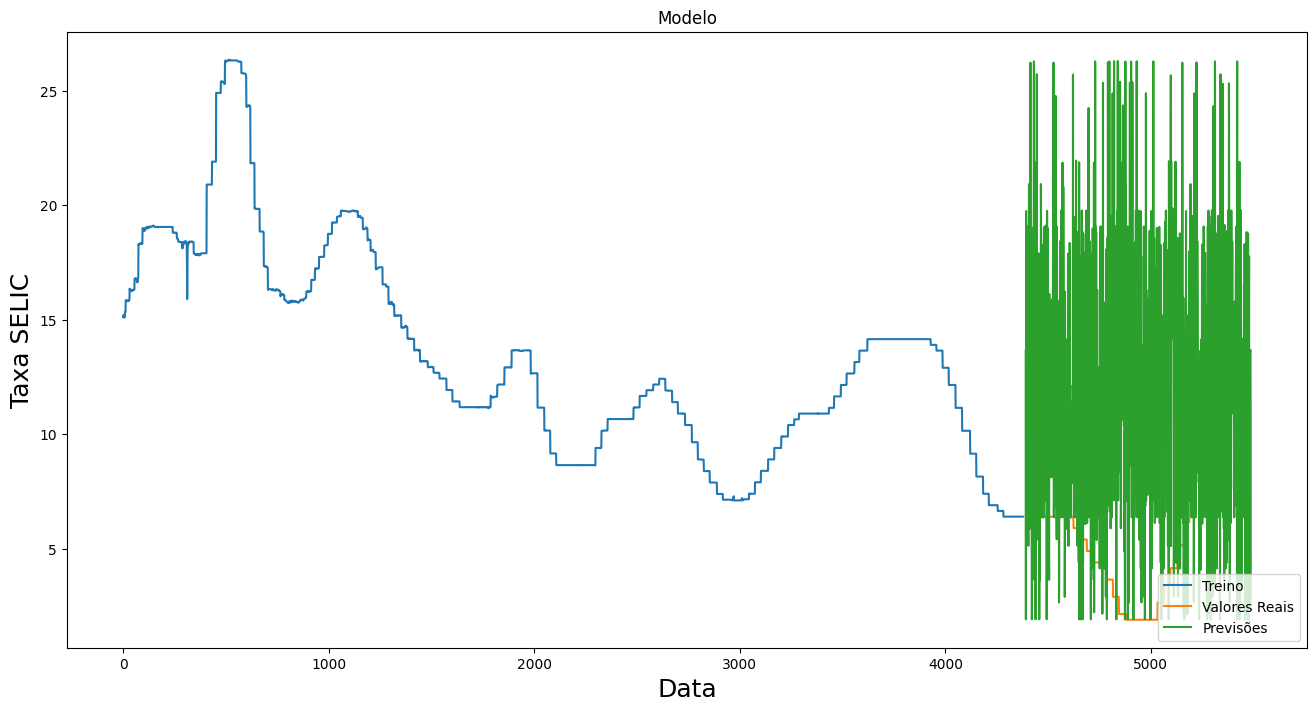

In [81]:
# Criar DataFrame 'valid' com o tamanho correto
valid = data[-len(test_predict):]  # Isso garante que o número de linhas em 'valid' seja igual ao número de previsões
valid['Predictions'] = test_predict
plt.figure(figsize=(16,8))
plt.title('Modelo')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Taxa SELIC', fontsize=18)
plt.plot(train['selic'])
plt.plot(valid[['selic', 'Predictions']])
plt.legend(['Treino', 'Valores Reais', 'Previsões'], loc='lower right')
plt.show()


1/1 [==============================] - 0s 24ms/step
            Prediction
2023-01-01   13.640751
2023-02-01   13.635232
2023-03-01   13.631585
2023-04-01   13.627852
2023-05-01   13.624438
2023-06-01   13.621329
2023-07-01   13.618425
2023-08-01   13.615622
2023-09-01   13.612836
2023-10-01   13.610009
2023-11-01   13.607104
2023-12-01   13.604107


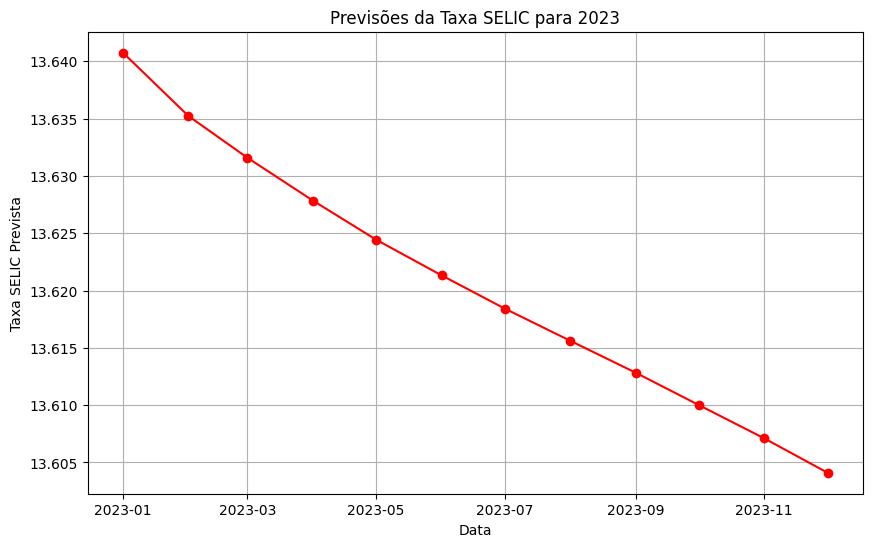

In [24]:
# ... código anterior ...

# Suponha que `X_test` contém os últimos dados de 2022
# Nós queremos gerar previsões para os meses de 2023

# Gerar previsões para o próximo ano
num_months_to_predict = 12  # Número de meses a prever em 2023
current_batch = X_test[-1].reshape((1, look_back, 1))  # Último lote de dados disponíveis

# Lista para manter as previsões
predictions = []

# Gerar previsões mês a mês
for i in range(num_months_to_predict):
    # Obter a previsão para o próximo mês
    current_pred = model.predict(current_batch)[0]

    # Adicionar a previsão à lista
    predictions.append(current_pred)

    # Atualizar o lote para incluir a nova previsão
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

# Inverter as previsões para a escala original
predictions = scaler.inverse_transform(predictions)

# Criar um DataFrame com as previsões
months_in_2023 = pd.date_range(start='2023-01-01', periods=num_months_to_predict, freq='MS')
predictions_df = pd.DataFrame(data=predictions, index=months_in_2023, columns=['Prediction'])

# Exibir as previsões
print(predictions_df)

# Plotar as previsões
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df['Prediction'], marker='o', linestyle='-', color='r')
plt.title('Previsões da Taxa SELIC para 2023')
plt.xlabel('Data')
plt.ylabel('Taxa SELIC Prevista')
plt.grid(True)
plt.show()


      Mês  Previsão  Valor Real  Diferença (%)
Fevereiro 13.635232       13.75       0.114768
    Março 13.631585       13.75       0.118415
     Maio 13.624438       13.75       0.125562
    Junho 13.621329       13.75       0.128671
   Agosto 13.615622       13.25      -0.365622
 Setembro 13.612836       12.75      -0.862836
 Novembro 13.607104       12.25      -1.357104


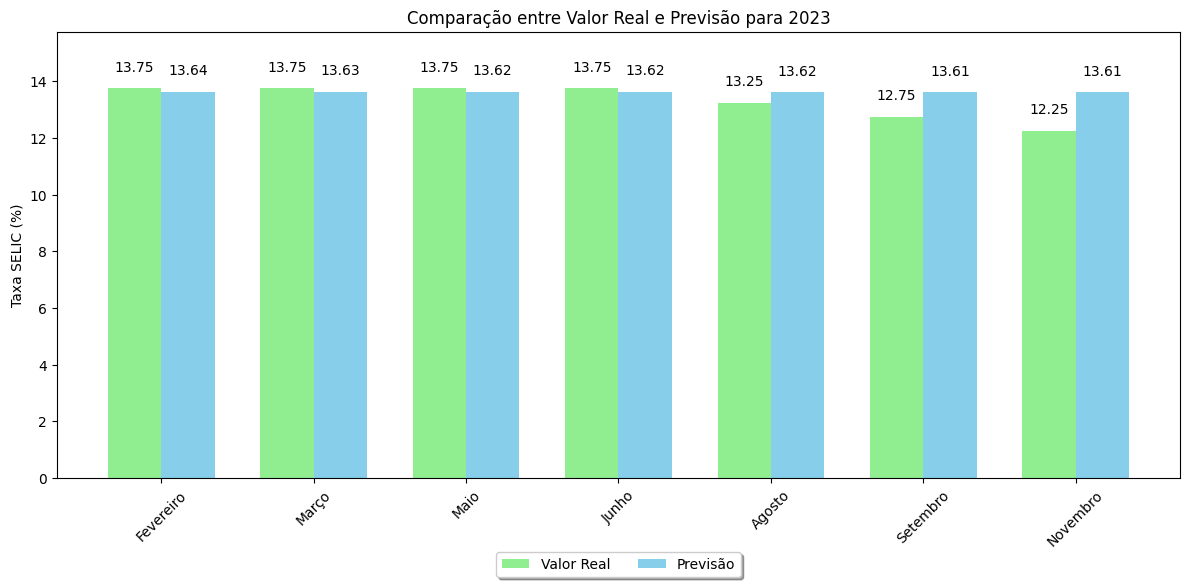

Erro Médio Absoluto (MAE): 0.4390
Erro Quadrático Médio (MSE): 0.3971
Raiz do Erro Quadrático Médio (RMSE): 0.6301


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

# Dados das previsões e valores reais
predictions_df
real_values = np.array([13.75, 13.75, 13.75, 13.75, 13.25, 12.75, 12.25])

# Meses correspondentes aos valores reais
months_in_2023 = ["Fevereiro", "Março", "Maio", "Junho", "Agosto", "Setembro", "Novembro"]

# Cálculo do MAE para cada mês
mae_by_month = mean_absolute_error(real_values, predictions)

# Criar um DataFrame para exibir os resultados
resultados_df = pd.DataFrame({
    'Mês': months_in_2023,
    'Previsão': predictions,
    'Valor Real': real_values,
    'Diferença (%)': (real_values - predictions)
})

# Exibir os resultados formatados como string
resultados_str = resultados_df.to_string(index=False)
print(resultados_str)

# Gráfico de barras
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(resultados_df['Mês']))
plt.bar(index, resultados_df['Valor Real'], bar_width, label='Valor Real', color='lightgreen', align='center')
plt.bar(index + bar_width, resultados_df['Previsão'], bar_width, label='Previsão', color='skyblue', align='center')
plt.title('Comparação entre Valor Real e Previsão para 2023')
plt.xlabel('Mês')
plt.ylabel('Taxa SELIC (%)')
plt.xticks(index + bar_width / 2, resultados_df['Mês'], rotation=45)
plt.grid(True)

# Ajustar os limites do eixo y para evitar que as bordas sejam cortadas
plt.ylim(0, max(max(resultados_df['Previsão']), max(resultados_df['Valor Real'])) + 2)


# Adicionar rótulos acima das barras
for i, (real, prev) in enumerate(zip(resultados_df['Valor Real'], resultados_df['Previsão'])):
    plt.text(i, real + 0.5, f'{real:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width, prev + 0.5, f'{prev:.2f}', ha='center', va='bottom', fontsize=10)

# Remover as grades
plt.grid(False)

# Adicionar legenda abaixo do gráfico
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.tight_layout()

# Exibir o gráfico de barras
plt.show()

# Valores reais e previsões em unidades absolutas
real_values_absolute = resultados_df['Valor Real']
predictions_absolute = resultados_df['Previsão']

# Calcular MAE, MSE e RMSE
mae = mean_absolute_error(real_values_absolute, predictions_absolute)
mse = mean_squared_error(real_values_absolute, predictions_absolute)
rmse = np.sqrt(mse)

# Exibir os resultados
print(f"Erro Médio Absoluto (MAE): {mae:.4f}")
print(f"Erro Quadrático Médio (MSE): {mse:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")


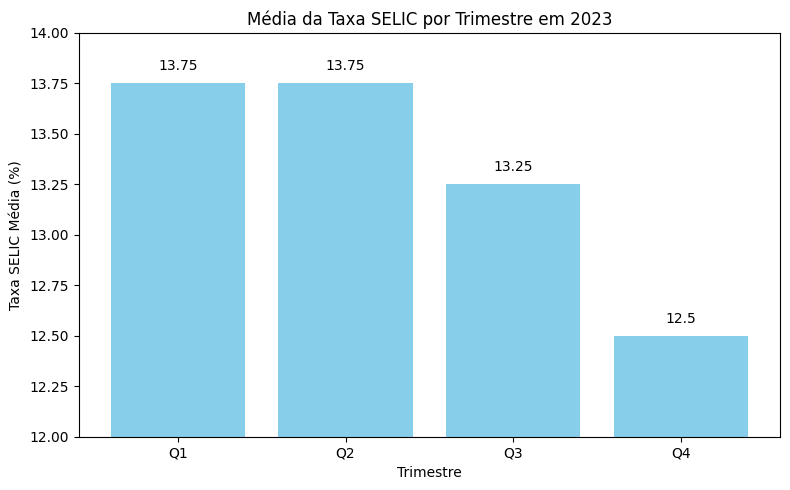

In [28]:
# Dados das médias da SELIC por trimestre
trimestres = ['Q1', 'Q2', 'Q3', 'Q4']
medias = [13.75, 13.75, 13.25, 12.5]

# Criar o gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(trimestres, medias, color='skyblue')

# Adicionar rótulos
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

# Configurar o gráfico
plt.title('Média da Taxa SELIC por Trimestre em 2023')
plt.xlabel('Trimestre')
plt.ylabel('Taxa SELIC Média (%)')
plt.ylim([12, 14])  # Definir o limite do eixo y para melhor visualização dos rótulos
plt.tight_layout()

# Mostrar o gráfico
plt.show()
